In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
eventDate = datetime.datetime(2011,6,8)#datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,6,8,4,0)#datetime.datetime(2011,5,16,7,0)
timeEnd = datetime.datetime(2011,6,8,7,0)#datetime.datetime(2011,5,16,10,0)
sapsTime = datetime.datetime(2011,6,8,5,30)#datetime.datetime(2011,5,16,8,36)
sapsRadList = [ "fhw" ]#[ "cvw" ]
selBeam = 9
sapsMlatRange = [ 50., 62. ]#[ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam
velScale = [ -500, 500 ]

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110608,300,1,0,-5.7955,24.2035,39.2449,-145.0924,12.5656,44.3930,143.6157,40,hok,2011-06-08 03:00:00,-11.4344
1,20110608,300,1,1,-2.5622,26.8421,39.7386,-144.9443,12.5755,44.9025,143.7975,40,hok,2011-06-08 03:00:00,-11.4245
2,20110608,300,1,2,-0.7420,26.4890,40.1807,-144.8334,12.5829,45.3574,143.9379,40,hok,2011-06-08 03:00:00,-11.4171
3,20110608,300,1,3,0.4915,3.9162,40.6033,-144.7371,12.5893,45.7913,144.0629,40,hok,2011-06-08 03:00:00,-11.4107
4,20110608,300,1,4,1.3994,3.9162,41.0157,-144.6486,12.5952,46.2139,144.1805,40,hok,2011-06-08 03:00:00,-11.4048


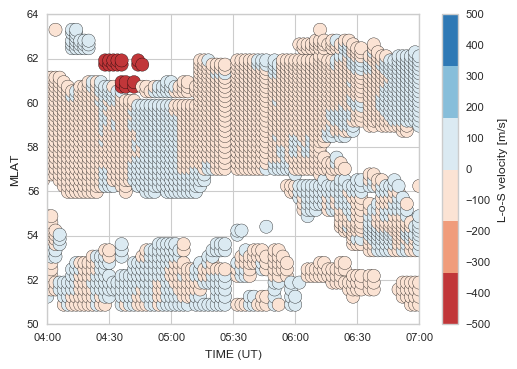

In [4]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == "cvw") &\
              (velsDF["beam"] == selBeam) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiPlot = ax.scatter( rtiDF["date"].values, rtiDF["MLAT"].values,\
           c=rtiDF["vLos"].values, cmap=seaMap,vmin=velScale[0], vmax=velScale[1], s=90. )
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-sctr-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


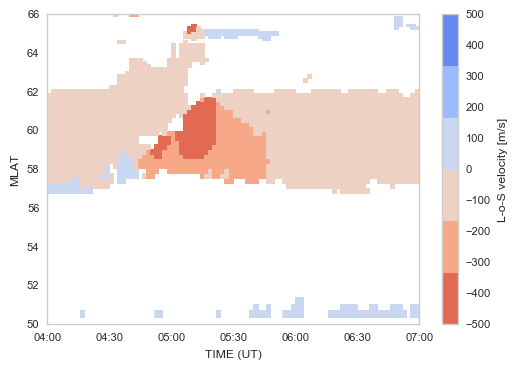

In [5]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == sapsRadList[0]) &\
              (velsDF["beam"] == selBeam) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [6]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]
# 5) Finally group by radar and beam number to
# discard velocities whose values are
cntPntsSAPSGrp = sapsDF.groupby( ["radCode", "beam"] ).size().reset_index()
# cntPntsSAPSGrp.columns = ["radCode", "beam", "nPoints"]
# sapsDF = pandas.merge( sapsDF, cntPntsSAPSGrp, on=["radCode", "beam"] )
# sapsDF = sapsDF[ sapsDF["nPoints"] >= sapsNpointsCutoff ]

1210


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


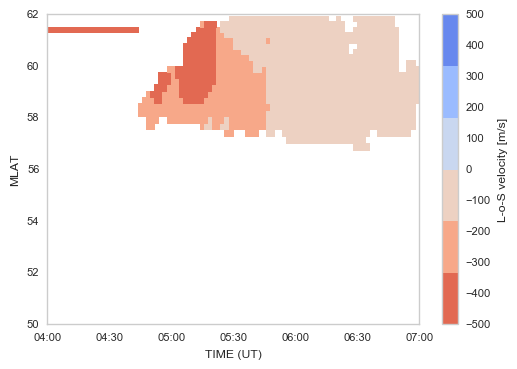

In [7]:
# sel data from a radar and beam
rtiDF = sapsDF[ (sapsDF["radCode"] == sapsRadList[0]) &\
               (sapsDF["beam"] == selBeam) ]
print len(rtiDF.index)
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=velScale[0],vmax=velScale[1])


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [50,62] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rt-saps-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [8]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))
# Get l-shell fitted velocities from
# the SAPS vLos at different time intervals
lshellDF = sapsDF[ sapsDF["date"] == sapsTime ]
# groupby rounded azimuth to 
# get median vLos to Lshell fit
lshellDF["azimRnd"] = lshellDF["azimCalcMag"].round()#apply(lambda x: custom_round(x, base=5))
selCols = [ "vLos", "MLAT", "normMLT", "azimRnd" ]
azimDF = lshellDF[selCols].groupby( ["azimRnd"] ).median().reset_index()
azimDF.columns = [ "azimRnd", "vLos_median", "MLAT_mean", "normMLT_mean" ]
azimStdDF = lshellDF[selCols].groupby( ["azimRnd"] ).std().reset_index()
azimStdDF.columns = [ "azimRnd", "vLos_std", "MLAT_std", "normMLT_std" ]
azimDF = pandas.merge( azimDF, azimStdDF, on="azimRnd" )
# discard azims with less count
azimCntDF = lshellDF.groupby("azimRnd").size().reset_index()
azimCntDF.columns = [ "azimRnd", "nPnts" ]
azimDF = pandas.merge( azimDF, azimCntDF, on="azimRnd" )
# discard azimuths where number of points is less than
# 50% of the maximum (observed across all azimuths)
azimDF["percCnt"] = azimDF["nPnts"]*100./azimDF["nPnts"].max()
azimDF = azimDF[ azimDF["percCnt"] >= 33. ]
print azimDF

    azimRnd  vLos_median  MLAT_mean  normMLT_mean   vLos_std  MLAT_std  \
0     -66.0   -207.05640   58.17170      -3.04375   4.556879  0.102248   
2     -64.0   -163.07810   58.71685      -3.03550  18.230344  1.298319   
3     -63.0   -187.41805   59.39540      -3.07060  10.806501  0.114693   
5     -61.0   -212.52935   58.89210      -2.93635   3.183041  0.122471   
6     -60.0   -184.75310   59.60785      -2.96705  54.925619  1.239248   
7     -59.0   -195.73555   59.33370      -2.90145  63.268733  1.512360   
8     -58.0   -218.37365   59.05075      -2.83580  38.964984  1.239547   
9     -57.0   -248.92400   57.69200      -2.65790  30.023703  1.295158   
10    -56.0   -160.08520   59.63200      -2.84310  68.174024  1.895454   
11    -55.0   -209.67580   59.22600      -2.75820  59.875175  1.379636   
12    -54.0   -179.72670   59.94475      -2.78240  61.769596  1.442532   
13    -53.0   -164.32390   60.64760      -2.80440  50.639059  1.379724   
14    -52.0   -224.11780   58.15430   

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


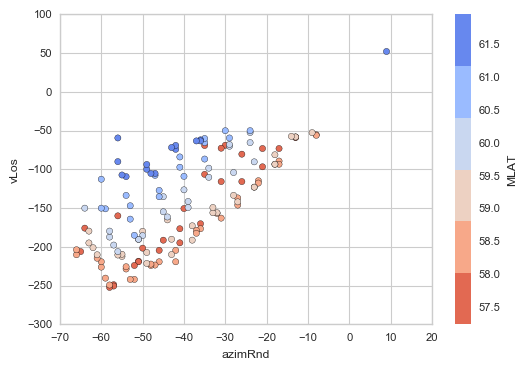

In [9]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
lshellDF.plot( kind='scatter',
              x='azimRnd',
              y='vLos',
              c='MLAT',
              s=20., cmap=seaMap, ax=ax)
fig1.savefig("../plots/lshell-test.pdf",bbox_inches='tight')

In [10]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

vMax---> 222.189091573 +/- 13.1857046455
delTheta---> -2.42727635244 +/- 3.20665582295


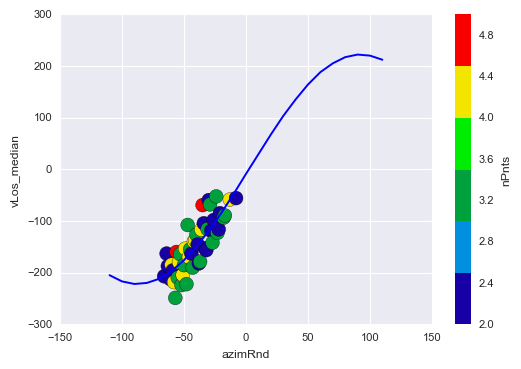

In [11]:
# Fit the data
popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                    azimDF["azimRnd"].T,\
                    azimDF['vLos_median'].T,
                   p0=initGuess)
# fitted params
print "vMax--->", popt[0],"+/-", pcov[0,0]**0.5
print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
# curve for plotting
thetaArr = range(-110, 120, 10)
vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
# Plots
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("spectral"))
azimDF.plot( kind='scatter',
              x='azimRnd',
              y='vLos_median',
              c='nPnts',
              s=100., cmap=seaMap, ax=ax)
ax.plot( thetaArr, vLosArr )

In [12]:
test = sapsDF[ sapsDF["date"] == sapsTime ]
print test[ ["MLAT", "normMLT"] ]

           MLAT  normMLT
433290  57.7988  -2.9319
433291  57.9510  -2.9764
433292  58.0994  -3.0212
433293  58.2440  -3.0663
433315  57.2936  -2.5757
433316  57.4945  -2.6166
433317  57.6920  -2.6579
433318  57.8862  -2.6996
433319  58.0770  -2.7417
433320  58.2643  -2.7843
433321  58.4482  -2.8272
433322  58.6286  -2.8705
433323  58.8055  -2.9143
433324  58.9787  -2.9584
433325  59.1483  -3.0030
433326  59.3143  -3.0479
433327  59.4765  -3.0933
433328  59.6349  -3.1391
433348  57.2410  -2.3987
433349  57.4739  -2.4369
433350  57.7038  -2.4755
433351  57.9306  -2.5146
433352  58.1543  -2.5541
433353  58.3750  -2.5940
433354  58.5925  -2.6344
433355  58.8068  -2.6752
433356  59.0180  -2.7165
433357  59.2260  -2.7582
433358  59.4306  -2.8004
433359  59.6320  -2.8431
...         ...      ...
433473  59.6163  -2.0356
433474  59.9457  -2.0613
433475  60.2736  -2.0875
433476  60.5999  -2.1141
433477  60.9245  -2.1413
433483  57.5222  -1.8020
433484  57.8773  -1.8219
433485  58.2307  -1.8422


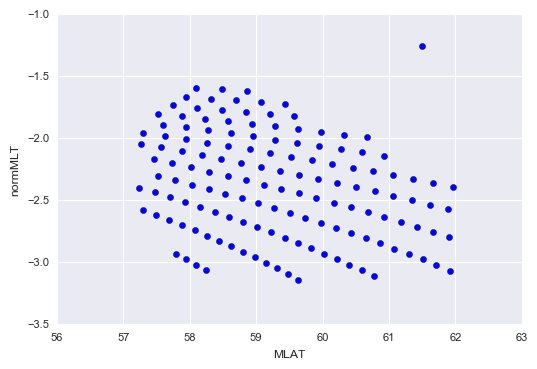

In [13]:
test.plot(x="MLAT",y="normMLT",kind="scatter")